In [1]:
# Import modules
import torch
import e3nn
import numpy as np
import random
from torch_geometric.datasets import MD17
from model import InteractionModel
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define constants
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataloader
TRAIN_SIZE = 800
EVAL_SIZE = 100
TEST_SIZE = 100

# Model
SCALE = -1.0
R_CUT = 20.0
MAX_Z = 10
DIM_ATOMS = 30
DIM_R = 1
MU_MIN = 0.0
MU_MAX = 20.0
STEP = 0.2
DIM_R = int(np.ceil((MU_MAX - MU_MIN) / STEP) + 1)
IRREPS_R = e3nn.o3.Irreps(f"{DIM_R}x0e")
IRREPS_SH = e3nn.o3.Irreps.spherical_harmonics(2)
IRREPS_FEATURE = IRREPS_R + IRREPS_SH
IRREPS_ATOM = e3nn.o3.Irreps(f"{DIM_ATOMS}x0e")
IRREPS_MID = e3nn.o3.Irreps("32x0e + 32x1o + 32x2e + 32x3o")
N_INTERACTIONS = 3

# Trainer
N_EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.001
EARLY_STOP_THRESHOLD = 3
MIN_EPOCHS = 10

DATASETS_PATH = "/home/sanghyeonl/git/toy/e3nn_potential/datasets"
CHECKPOINT_PATH = "/home/sanghyeonl/git/toy/e3nn_potential/model.pt"
TARGET_MOLECULE = "revised aspirin"

In [3]:
def loss_fn(predict, label):
    return (predict - label) ** 2

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
# Load datasets (Multiple molecules, altogether)
molecules = [
    "revised toluene",
    "revised salicylic acid",
    "revised paracetamol",
    "revised aspirin",
    "revised azobenzene",
]

raw_datasets = [MD17(DATASETS_PATH, molecule).to(device) for molecule in molecules]
datasets = []
for raw_dataset in raw_datasets:
    indices = random.sample(
        np.arange(len(raw_dataset)).tolist(), TRAIN_SIZE + EVAL_SIZE + TEST_SIZE
    )
    indices = np.split(indices, [TRAIN_SIZE, TRAIN_SIZE + EVAL_SIZE])

    train_dataset = [data.to_dict() for data in raw_dataset[indices[0]]]
    np.random.shuffle(train_dataset)
    eval_dataset = [data.to_dict() for data in raw_dataset[indices[1]]]
    test_dataset = [data.to_dict() for data in raw_dataset[indices[2]]]
    dataset = {
        "name": raw_dataset.name,
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "test_dataset": test_dataset,
    }
    datasets.append(dataset)

In [7]:
# Run train and evalutaion loop
results = []

for dataset in datasets:
    print(f"===   Target Molecule : {dataset['name']}   ===")
    best_loss = torch.inf
    early_stop_counter = 0

    model = InteractionModel(
        device=device,
        scale=SCALE,
        activation_fn=torch.nn.SiLU(),
        r_cut=R_CUT,
        max_z=MAX_Z,
        dim_atoms=DIM_ATOMS,
        mu_min=MU_MIN,
        mu_max=MU_MAX,
        step=STEP,
        irreps_feature=IRREPS_FEATURE,
        irreps_atom=IRREPS_ATOM,
        irreps_mid=IRREPS_MID,
        n_interactions=N_INTERACTIONS,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    train_loss = []
    eval_loss = []
    best_plot = []
    for epoch in range(N_EPOCHS):
        model.train()
        train_loss.append([])
        plot = []
        for i, batch in enumerate(
            tqdm(train_dataset, desc=f"Epoch #{epoch + 1:02} (Train)")
        ):
            data, readout = model(batch)
            loss = loss_fn(data["e"], readout)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            plot.append((data["e"].item(), readout.item()))

            train_loss[-1].append(loss.item())

        eval_loss.append([])
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(
                tqdm(eval_dataset, desc=f"Epoch #{epoch + 1:02} (Valid)")
            ):
                data, readout = model(batch)
                loss = loss_fn(data["e"], readout)
                eval_loss[-1].append(loss.item())

        if np.mean(eval_loss[-1]) < best_loss:
            best_loss = np.mean(eval_loss[-1])
            best_plot = plot
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_loss,
                },
                CHECKPOINT_PATH,
            )
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= EARLY_STOP_THRESHOLD and epoch > MIN_EPOCHS:
            break

    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]

    test_plot = []
    test_loss = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_dataset)):
            data, readout = model(batch)
            test_plot.append([data["e"].item(), readout.item()])
            test_loss.append(loss_fn(data["e"].item(), readout.item()))

    result = {
        "name": dataset["name"],
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "test_loss": test_loss,
        "best_loss": best_loss,
        "best_plot": best_plot,
        "test_plot": test_plot,
    }
    results.append(result)

/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


===   Target Molecule : revised toluene   ===


100%|██████████| 100/100 [00:00<00:00, 500.86it/s]
/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


===   Target Molecule : revised salicylic acid   ===


100%|██████████| 100/100 [00:00<00:00, 519.07it/s]
/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


===   Target Molecule : revised paracetamol   ===


100%|██████████| 100/100 [00:00<00:00, 519.15it/s]
/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


===   Target Molecule : revised aspirin   ===


100%|██████████| 100/100 [00:00<00:00, 411.95it/s]
/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


===   Target Molecule : revised azobenzene   ===


100%|██████████| 100/100 [00:00<00:00, 406.91it/s]


revised toluene


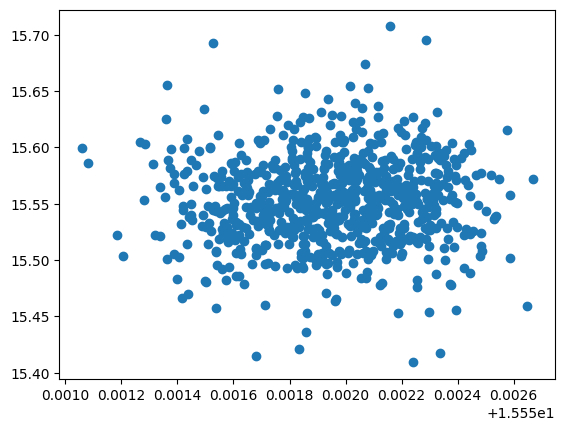

revised salicylic acid


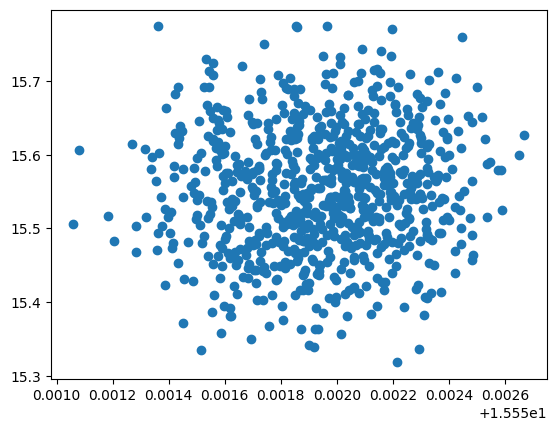

revised paracetamol


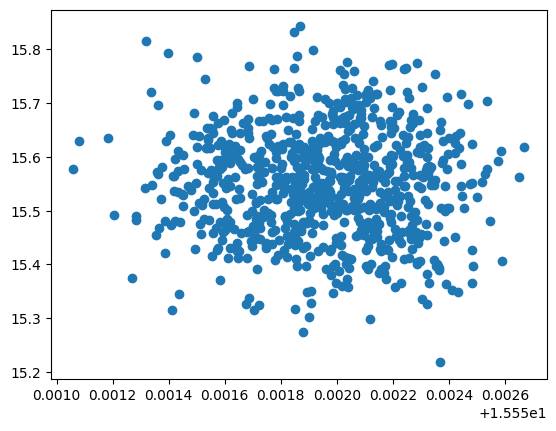

revised aspirin


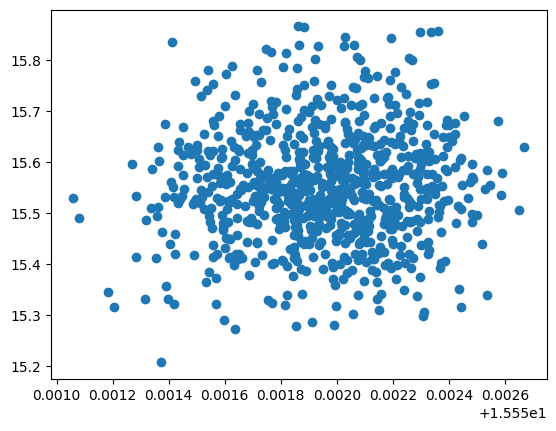

revised azobenzene


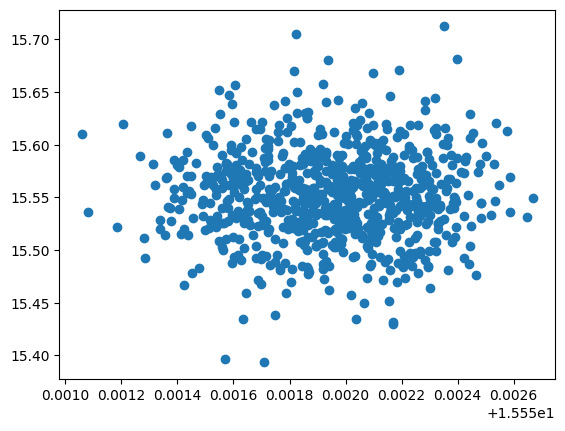

In [34]:
# plt.figure(figsize=(12, 10))

for result in results:
    print(result["name"])
    x = [data[0] for data in result["best_plot"]]
    y = [data[1] for data in result["best_plot"]]
    plt.scatter(x, y)

    plt.show()